# Machine Learning With Android and Arduino

## Introduction

Many cars now come with adjustable suspension that the driver sets to match the road conditions and the desired driving experience. I thought it would be interesting to design a road surface detector using machine learning that would adjust the suspension based on the road surface, rather than leaving it to the driver. To keep things simple I decided I would start small scale, with a remote-controlled (RC) car.

I selected the Arduino Uno and MPU-6050 tri-axial accelerometer as the data acquisition and sensor system. I coded an Android application, Accel Plot, that connects to the Arduino via Bluetooth. Accel Plot stores and plots the data from the MPU-6050 accelerometer. I collected data on three different surfaces: carpet, cobblestone, and ceramic tile. The goal of the project is to design a classification scheme that will identify the surface based on readings from the tri-axial accel. This project imports the data from the Accel Plot and Arduino project (http://www.instructables.com/id/Realtime-MPU-6050A0-Data-Logging-With-Arduino-and-/), performs some exploratory analysis, and uses decision trees to classify the data.

## Instrumentation Setup

I fabricated a shield for the Arduino Uno that included the HC-05 Bluetooth module and the MPU-6050 accelerometer/gyrometer sensors. For this project only the accelerometers of the MPU-6050 are used. The figure below shows the shield layout.

![title](img/ShieldLayout_sm.jpg)

I mounted the shield to a small remote-controlled (RC) car, as shown in the photo below. This was a safe platform for me to test the data collection and operate the Android data collection device. Channel 1 is the x-axis accelerometer and is positive when the car moves backward, channel 2 is the y-axis accelerometer and is positive when the car moves toward the driver, and channel 3 is the z-axis accelerometer and is positive when the car moves upward.

![title](img/ChannelAxisMap.jpg)

## Data Collection

I used the Accel Plot (https://play.google.com/store/apps/details?id=com.dairyroadsolutions.accelplot&hl=en) application to display and collect the data. Each file is 1 minute long (15,000 samples). I made two different runs on each surface. The image below shows the three different surfaces.


![title](img/surfaces.JPG)

# Notebook Setup

This line is required to display the plots in the notebook

In [1]:
%matplotlib inline

# Definitions and Functions

This value is defined in the Arduino code and documented in "Bluetooth.java" in the application.

In [2]:
D_SAMPLING_FREQUENCY = 250.0

Imports the libraries and defines the functions we will be using.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
plt.style.use('ggplot')
from scipy.interpolate import interp1d

Pulls in the data for each channel from Accel Plot data files.

In [4]:
def getChannelData(iChannel, strTestCase):
    cwd = os.getcwd()
    cwd = cwd+'\\TrainingData\\'+strTestCase

    lst_files = []
    for (dirpath, dirnames, filenames) in os.walk(cwd):
        lst_files.extend(filenames)
        break
        
    str_substr = 'Trace0' + str(iChannel)
    str_data_files = [str_test for str_test in lst_files if str_substr in str_test]
    
    for idx in range(0, len(str_data_files)):
        fh = open(cwd+'\\'+str_data_files[idx], 'rb')
        # read the data into numpy
        if(idx==0):
            xEnd = np.fromfile(fh, dtype=('>f'))
        else:
            xEnd = np.append(x, np.fromfile(fh, dtype=('>f')))
        fh.close()
    
    # We have to switch the underlying NumPy array to native system
    # Great write up at: http://pandas.pydata.org/pandas-docs/stable/gotchas.html. 
    # If you don't do this you get an error: ValueError: Big-endian buffer not supported on little-endian compiler
    x = xEnd.byteswap().newbyteorder()
    
    return (x,str_data_files)

Pads the data frame with the closest valid sample. This is needed when calculating rolling means, maximums, etc.

In [5]:
def padDataFrame(dfData, idx):

    for column in dfData:
        fTemp =  float(dfData[column].iloc[idx:(idx+1)])
        dfData[column].iloc[0:idx] = fTemp
        fTemp = float(dfData[column].iloc[-idx-1:-idx])
        dfData[column].iloc[-idx:] = fTemp
    
    return dfData

Calculates a rolling (moving) mean for the data frame. 

In [6]:
def getDataFrameRM(dfData, window_size, bRename=True):
    
    # These lines add the rolling average
    dfDataRM = dfData.rolling(window=window_size, center=True).mean()

    if( bRename):
        dfDataRM.columns = dfDataRM.columns+'_rm'
    
    # zero-indexed, no need to add 1
    idx = int(window_size/2)

    # Pad with the closest good value
    dfDataRM = padDataFrame(dfDataRM, idx)

    return dfDataRM

Calculates the rolling kurtosis.

In [7]:
def getDataFrameKR(dfData, window_size):
    
    # These lines add the rolling kurtosis
    dfDataKR = dfData.rolling(window=window_size, center=True).kurt()

    dfDataKR.columns = dfDataKR.columns+'_kr'
    
    # zero-indexed, no need to add 1
    idx = int(window_size/2)

    # Pad with the closest good value
    dfDataKR = padDataFrame(dfDataKR, idx)

    return dfDataKR

Implements a clever way of calculating the rolling Root-Mean-Square (RMS) values, from: http://stackoverflow.com/questions/8245687/numpy-root-mean-squared-rms-smoothing-of-a-signal.

In [8]:
def getRMS(data, window_size):
    data2 = np.power(data,2)
    window = np.ones(window_size)/float(window_size)
    return np.sqrt(np.convolve(data2, window, 'same'))

Returns a new data frame with rolling RMS values.

In [9]:
def getDataFrameRMS(dfData, window_size):
    
    dfRMS = dfData.copy(deep=True)
    
    for column in dfData:
        data = np.array(dfData[column])
        dfRMS[column] = getRMS(data, window_size)
        
    dfRMS.columns = dfData.columns+'_rms'
    
    # zero-indexed, no need to add 1
    idx = int(window_size/2)
    
    dfRMS = padDataFrame(dfRMS, window_size)
        
    return dfRMS

Calculates peak values for each column in the entire data frame. The signal processing model includes: remove the mean, rectify the signal, restore the mean, and keep the rolling maximum values.

In [10]:
def getDataFramePk(dfData, window_size, bRollingMeanOffset = True):
    
    # We want to rectify about the mean
    if (bRollingMeanOffset):
        mn = getDataFrameRM(dfData, window_size, bRename=False)
    else:
        mn = dfData.mean()
        
    dfPk = dfData-mn
    dfPk = dfPk.abs()
    dfPk = dfPk+mn
    
    # Rolling maximum
    dfPk = dfPk.rolling(window = window_size, center=True).max()
    
    # correct the column names    
    dfPk.columns = dfPk.columns+'_pk'
    
    # zero-indexed, no need to add 1
    idx = int(window_size/2)
    
    # Pad with the closest good value
    dfPk = padDataFrame(dfPk, idx)
        
    return dfPk

Calculates the crest factor (ratio of peak to RMS) for each column in a data frame.

In [11]:
def getDataFrameCrest(dfData, dfDataPk, dfDataRMS):
    
    dfCrest = dfDataPk.copy(deep=True)
    
    iCol = len(dfDataPk.columns)
    
    for idxCol in range(0,iCol):
        dataPk = np.array(dfDataPk.ix[:,idxCol])
        dataRMS = np.array(dfDataRMS.ix[:,idxCol])
        dfCrest.ix[:,idxCol] = np.divide(dataPk, dataRMS)
        
    dfCrest.columns = dfData.columns+'_cr'
        
    return dfCrest


Pulls the arrays from the data file function into a single data frame and adds the extracted values to the data frame.

In [12]:
def getDataAsFrame(strTestCase, strClass, bScaleData=True):
    
    # Read the data in
    (x1,strFiles1) = getChannelData(1,strFolder)
    (x2,strFiles2) = getChannelData(2,strFolder)
    (x3,strFiles3) = getChannelData(3,strFolder)
    (x4,strFiles4) = getChannelData(4,strFolder)
    t = np.divide(range(0,len(x1)),float(D_SAMPLING_FREQUENCY))

    # Construct the data frame
    dfData = pd.DataFrame(data={('t'):t,
                                ('Ch1'):x1, 
                                ('Ch2'):x2, 
                                ('Ch3'):x3, 
                                ('Ch4'):x4,
                                'Surface':strClass,
                                'File':strTestCase})

    data_cols = [col for col in dfData.columns if 'Ch' in col]

    # Rolling average
    window_size_rm = 50
    dfDataRM = getDataFrameRM(dfData[data_cols], window_size_rm, bRename=False)

    # Rolling mean residual (basically, highpass filtered, high frequency, signal)
    dfDataHF = dfData[data_cols] - dfDataRM
    dfDataHF.columns = dfDataHF.columns+'_hf'
    
    # Peak of the high frequency signal
    window_size_hp_pk = 5
    dfDataHFPk = getDataFramePk(dfDataHF, window_size_hp_pk)

    # Velocity of high frequency signal
    #dfDataVL = (dfData[data_cols] - dfDataRM).cumsum()
    dfDataVL = (dfDataRM-dfDataRM.mean()).cumsum()
    dfDataVL.columns = dfDataVL.columns+"_vl"
    
    # Now that we are through subtracting, rename the rolling mean columns
    dfDataRM.columns = dfDataRM.columns+'_rm'

    # Rolling RMS
    window_size = 11
    dfDataRMS = getDataFrameRMS(dfData[data_cols], window_size)

    # Rolling peak value
    window_size = 25
    dfDataPk = getDataFramePk(dfData[data_cols], window_size)

    # Peak value of the rolling mean
    window_size_rm_pk = window_size_rm*5
    dfDataRM_Pk = getDataFramePk(dfDataRM, window_size_rm_pk, bRollingMeanOffset = True)

    # Aggregate the dataframes
    dfData = pd.concat([dfData, dfDataRM, dfDataRMS, dfDataHF, dfDataHFPk, dfDataPk, dfDataRM_Pk, dfDataVL],
                       axis=1)
    
    return dfData

Appends one dataframe to another.

In [13]:
def appendDataAsFrame(strTestCase, dfData, strClass):
    dfNew = getDataAsFrame(strTestCase, strClass)
    dfDataOut = dfData.append(dfNew)
    dfDataOut = dfDataOut.reset_index(drop=True)

    return dfDataOut

Plots the signal features against the raw data.

In [14]:
def plotFeatures(dfDataPlot, strColName):
    
    fig, axes = plt.subplots(nrows=3, ncols=2)
    fig.subplots_adjust(wspace=.5, hspace=0.5)
    
    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_rm'], 
                     ax=axes[0,0], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName+" Rolling Mean")

    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_rms'], 
                     ax=axes[0,1], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName+" RMS")

    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_pk'], 
                     ax=axes[1,0], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName+" Peak")

    ax = dfDataPlot.plot(x='t', y=[strColName+"_rm", strColName+'_rm_pk'], 
                     ax=axes[1,1], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName+" Peak of Rolling Mean")
    
    ax = dfDataPlot.plot(x='t', y=[strColName+"_hf", strColName+"_hf_pk"], 
                     ax=axes[2,0], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName+" High-frequency Peak")
    
    ax = dfDataPlot.plot(x='t', y=[strColName+"_vl"], 
                     ax=axes[2,1], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName+" Velocity")


Plots the timebase data in the data frame.

In [15]:
def plotFolder(dfDataPlot):
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.subplots_adjust(wspace=.5, hspace=0.5)
    
    strColName = 'Ch1'
    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_rm', strColName+'_pk'], 
                     ax=axes[0,0], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

    strColName = 'Ch2'
    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_rm', strColName+'_pk'], 
                     ax=axes[0,1], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

    strColName = 'Ch3'
    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_rm', strColName+'_pk'], 
                     ax=axes[1,0], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

    strColName = 'Ch4'
    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_rm', strColName+'_pk'], 
                     ax=axes[1,1], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

Plots the histograms of the different classes of data.

In [16]:
def plotClasses(dfData, strSuff):
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    strClass = ['Cobble', 'Tile', 'Carpet']

    dfData1 = dfData.loc[dfData['Surface'] == strClass[0]]
    dfData1.columns = dfData1.columns+'_'+strClass[0]
    dfData1 = dfData1.reset_index(drop=True)
    dfData2 = dfData.loc[dfData['Surface'] == strClass[1]]
    dfData2.columns = dfData2.columns+'_'+strClass[1]
    dfData2 = dfData2.reset_index(drop=True)
    dfData3 = dfData.loc[dfData['Surface'] == strClass[2]]
    dfData3.columns = dfData3.columns+'_'+strClass[2]
    dfData3 = dfData3.reset_index(drop=True)
    dfDataPlot = pd.concat([dfData1, dfData2, dfData3], axis=1)

    strSeries = ['Ch1_' + strSuff + s for s in strClass]
    ax1 = dfDataPlot[strSeries].plot.hist(figsize=(12,12), ax=axes[0, 0], alpha = 0.4, bins=50)

    strSeries = ['Ch2_' + strSuff + s for s in strClass]
    ax1 = dfDataPlot[strSeries].plot.hist(figsize=(12,12), ax=axes[0, 1], alpha = 0.4, bins=50)

    strSeries = ['Ch3_' + strSuff + s for s in strClass]
    ax1 = dfDataPlot[strSeries].plot.hist(figsize=(12,12), ax=axes[1, 0], alpha = 0.4, bins=50)

    #strSeries = ['Ch4_' + strSuff + s for s in strClass]
    #ax1 = dfDataPlot[strSeries].plot.hist(figsize=(12,12), ax=axes[1, 1], alpha = 0.4, bins=50)


Plots correlation by channel.

In [17]:
def plotCorrChannel(strChannel, cmap_in):
    
    # Section the data and calc correlation matrix
    plot_cols = [col for col in dfData.columns if strChannel in col]
    dfPlot = dfData[plot_cols]
    correlations = dfPlot.corr()
    names = list(dfPlot)
    iCols = len(dfPlot.columns)
    
    # plot correlation matrix
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap=cmap_in)
    fig.colorbar(cax)
    ticks = np.arange(0,iCols,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

Checks the correlation of the tri-axial accel.

In [18]:
def plotCorrAccel(dfData, cmap_in):
    
    # Section the data and calc correlation matrix
    plot_cols = ['Ch1', 'Ch2', 'Ch3']
    dfPlot = dfData[plot_cols]
    correlations = dfPlot.corr()
    names = list(dfPlot)
    iCols = len(dfPlot.columns)
    
    # plot correlation matrix
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap=cmap_in)
    fig.colorbar(cax)
    ticks = np.arange(0,iCols,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

Plots the features for the different surfaces.

In [19]:
def plotCorrFeature(dfData, strFeature, strFileName, cmap_in):
    plot_cols=['Tile', 'Carpet', 'Cobble']
    
    
    dfPlot = pd.DataFrame(data={(strFeature+'_'+plot_cols[0]):np.array(dfData[strFeature].loc[dfData['Surface'] == plot_cols[0]]),
                                (strFeature+'_'+plot_cols[1]):np.array(dfData[strFeature].loc[dfData['Surface'] == plot_cols[1]]), 
                                (strFeature+'_'+plot_cols[2]):np.array(dfData[strFeature].loc[dfData['Surface'] == plot_cols[2]])})
    
    
    #fig0 = plt.figure(figsize=(10,10))
    #plt.plot(dfPlot[strFeature+'_'+plot_cols[0]])
    
    correlations = dfPlot.corr()
    names = list(dfPlot)
    iCols = len(dfPlot.columns)
    
    # plot correlation matrix
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.grid(False)
    cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap=cmap_in)
    fig.colorbar(cax)
    ticks = np.arange(0,iCols,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.savefig(strFileName, format='pdf')
    plt.show() 
    
    return plt

Harmonizes the plot colors across the different formats.

In [20]:
plot_colors_surf = [(51.0/255.0, 102.0/255.0, 154.0/255.0),
                    (246.0/255.0, 134.0/255.0, 31.0/255.0),
                    (243.0/255.0, 202.0/255.0, 47.0/255.0)]

In [21]:
x_vals = np.linspace(0,2, num=3)
x_vals_fine = np.linspace(0,2, num=100)

r_vals = np.array([plot_colors_surf[0][0], plot_colors_surf[1][0], plot_colors_surf[2][0]])
r_fun = interp1d(x_vals, r_vals)

g_vals = np.array([plot_colors_surf[0][1], plot_colors_surf[1][1], plot_colors_surf[2][1]])
g_fun = interp1d(x_vals, g_vals)

b_vals = np.array([plot_colors_surf[0][2], plot_colors_surf[1][2], plot_colors_surf[2][2]])
b_fun = interp1d(x_vals, b_vals)

mat_vals = np.append([r_fun(x_vals_fine)], [g_fun(x_vals_fine)], axis=0)
mat_vals = np.transpose(np.append(mat_vals, [b_fun(x_vals_fine)], axis=0))
plot_colors_surf_fine = tuple(map(tuple, mat_vals))

In [22]:
cmap_surf = ListedColormap(plot_colors_surf)
cmap_surf_r = ListedColormap(cmap_surf.colors[::-1])
cmap_surf_fine = ListedColormap(plot_colors_surf_fine)
cmap_surf_fine_r = ListedColormap(cmap_surf_fine.colors[::-1])


# Exploratory Analysis  
Begin by getting the data into Python. Later this data will be split into two independent data sets, one we will use to train the model and another that will be used as a final test. The functions also build the features (rolling mean, RMS, peak, etc.) from the raw signal.

In [23]:
strClass = 'Cobble'
strFolder = 'Cobble1'
dfData = getDataAsFrame(strFolder, strClass)
strFolder = 'Cobble2'
dfData = appendDataAsFrame(strFolder, dfData, strClass)

strClass = 'Carpet'
strFolder = 'Carpet1'
dfData = appendDataAsFrame(strFolder, dfData, strClass)
strFolder = 'Carpet2'
dfData = appendDataAsFrame(strFolder, dfData, strClass)

strClass = 'Tile'
strFolder = 'Tile1'
dfData = appendDataAsFrame(strFolder, dfData, strClass)
strFolder = 'Tile2'
dfData = appendDataAsFrame(strFolder, dfData, strClass)

The three accelerometers on the MPU-6050 are physically orthogonal. If they are operating correctly (low noise and low cross-axis sensitivity), they should be informationally orthogonal as well. To check this, the three channels will be plotted on a correlated plot. Everything off the diagonals should be uncorrelated.

C:\Users\Rainy\AppData\Local\Temp/ipykernel_20236/104008357.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cax)


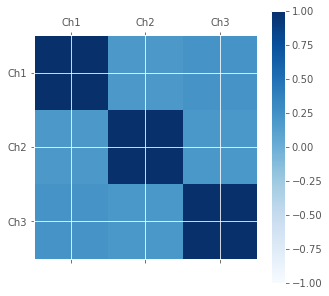

In [24]:
plotCorrAccel(dfData, plt.cm.Blues)

Next, plot the signal features against the signal itself to be sure the feature extraction algorithms are working correctly.

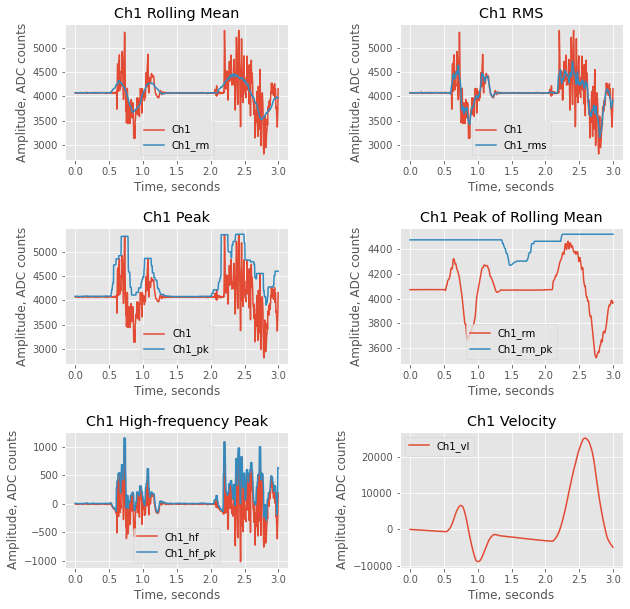

In [25]:
plotFeatures(dfData.loc[dfData['Surface'] == 'Carpet'].iloc[:750], strColName="Ch1")
plt.savefig("TimeBaseStart.pdf", format='pdf')

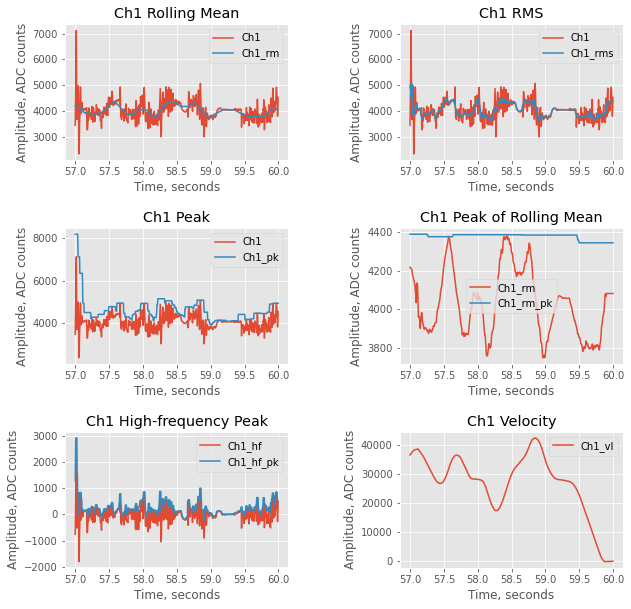

In [26]:
plotFeatures(dfData.loc[dfData['Surface'] == 'Carpet'].tail(750), strColName="Ch1")
plt.savefig("TimeBaseEnd.pdf", format='pdf')

Looks like the signal features are being extracted correctly; let's see how they relate to each other. The raw signal, Ch1, is uncorrelated with nearly all the signal features, except the high frequency signal Ch1_hf.  Although not plotted, it is similar for Ch2 and Ch3.

C:\Users\Rainy\AppData\Local\Temp/ipykernel_20236/529817162.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cax)


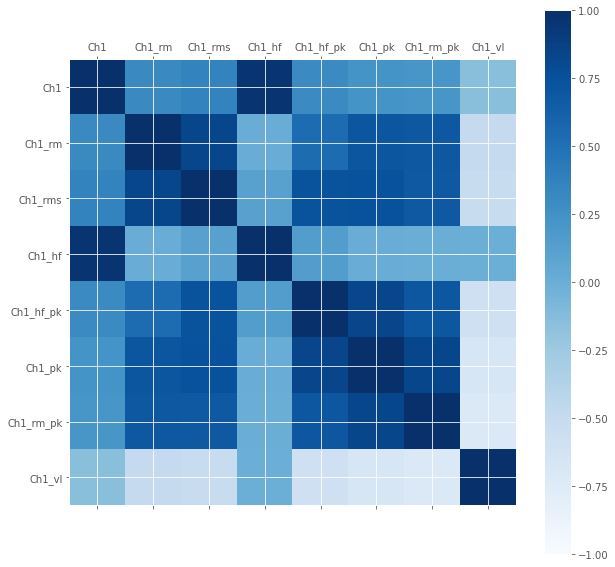

In [27]:
strChannel = 'Ch1'
plotCorrChannel(strChannel, plt.cm.Blues)

Plot out the carpet data. This surface was compliant so this should have lowest overall amplitudes. Each plot shows the acquired data (red line), the rolling mean value (blue line), and the peak value (purple line).

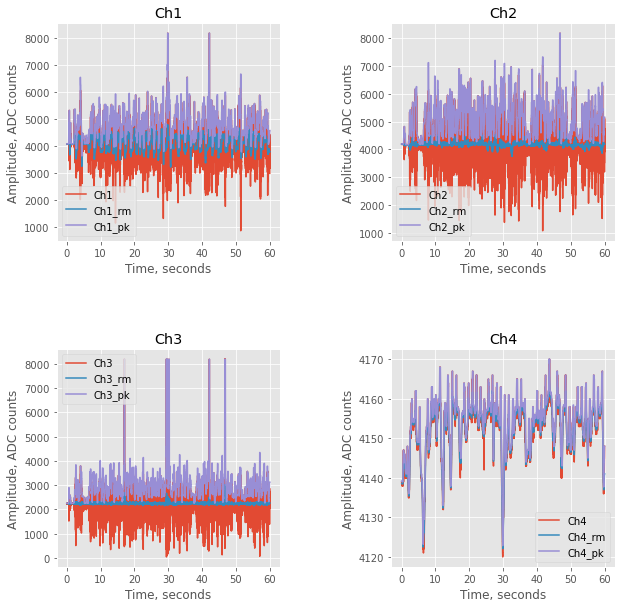

In [28]:
plotFolder(dfData.loc[dfData['File'] == 'Carpet1'])
plt.savefig("Carpet1Timebase.pdf", format='pdf')

Now plot the data from the tile. This surface is harder so there should be higher amplitudes, especially in the vertical direction (channel 3, z-axis).

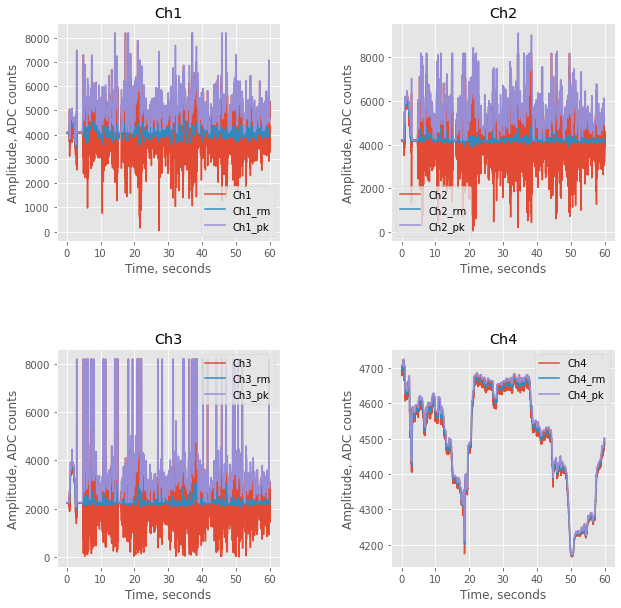

In [29]:
plotFolder(dfData.loc[dfData['File'] == 'Tile1'])
plt.savefig("Tile1Timebase.pdf", format='pdf')

Now plot the data from the cobblestone. This surface is both hard and rough so this has the highest amplitudes.

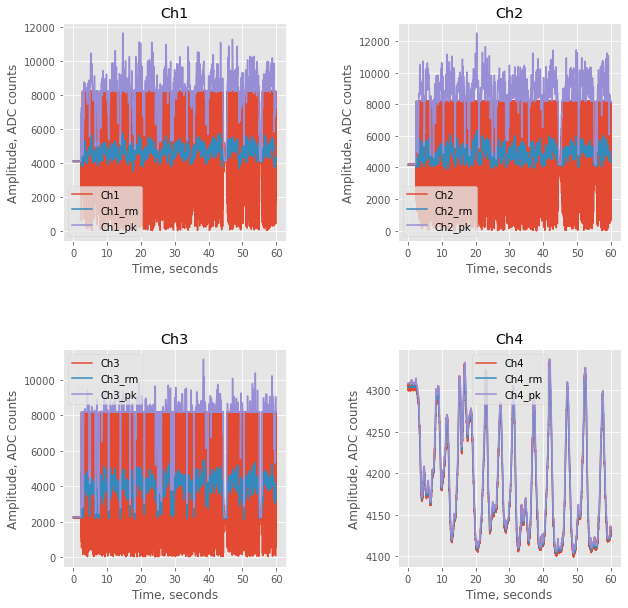

In [30]:
plotFolder(dfData.loc[dfData['File'] == 'Cobble1'])
plt.savefig("Cobble1Timebase.pdf", format='pdf')

### Normalize Data

The remaining plots and analysis will be simplified if the data is normalized.

In [31]:
data_cols = [col for col in dfData.columns if 'Ch' in col]
dfMean = dfData[data_cols].mean()
dfData[data_cols] = dfData[data_cols]-dfMean
dfStd = dfData[data_cols].std()
dfData[data_cols] = dfData[data_cols]/dfStd

### Analysis of Distributions

Next, the distributions of the features are plotted on top of each other. In an ideal world, each of the 3 cases (tile, carpet, and cobblestone) would be far apart. In the real world it won't be that be clear. This section shows the histograms for the raw signal. The accel signals are all right on top of each other. 

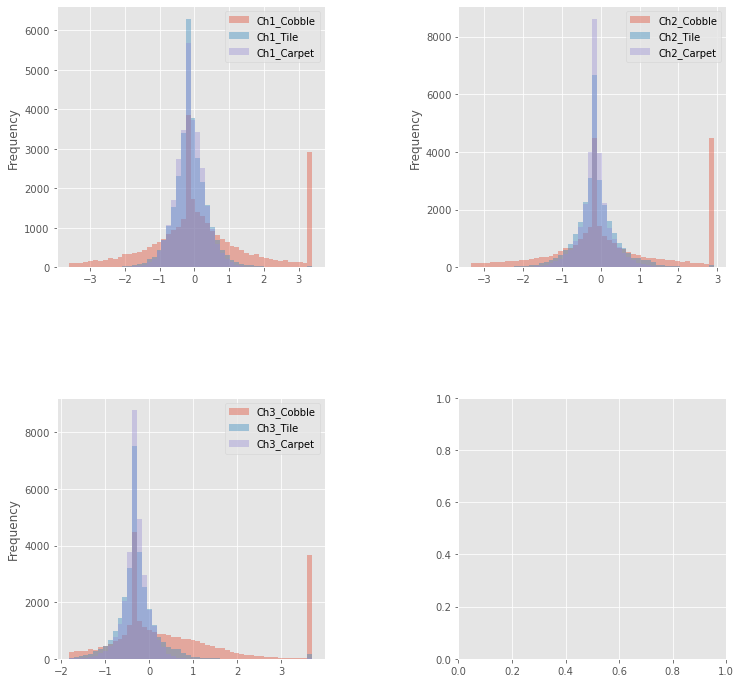

In [32]:
strSuff = ''
plotClasses(dfData, strSuff)

This is the rolling mean ('rm') data. The cobblestone histogram is moving away from the tile and carpet, but not enough.

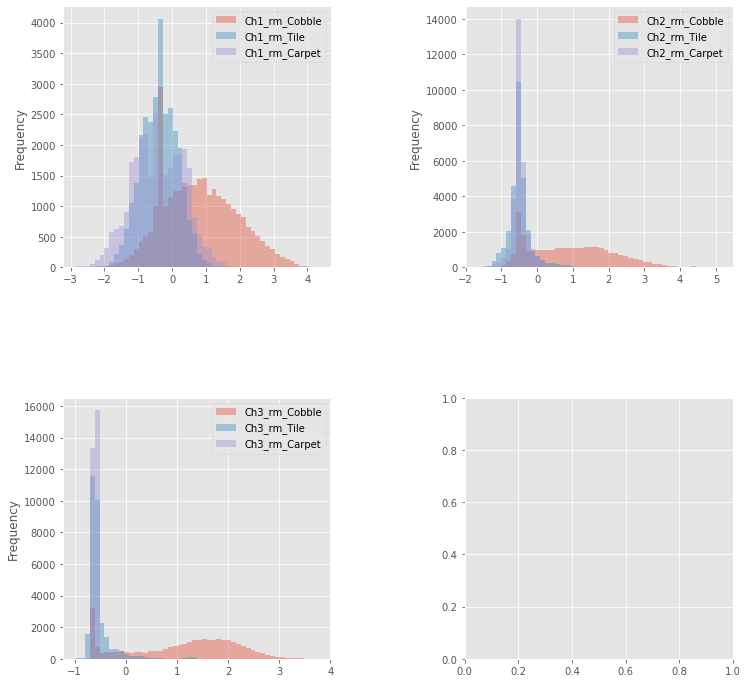

In [33]:
strSuff = 'rm_'
plotClasses(dfData, strSuff)

RMS is getting better separation, but the tile and carpet are still together.

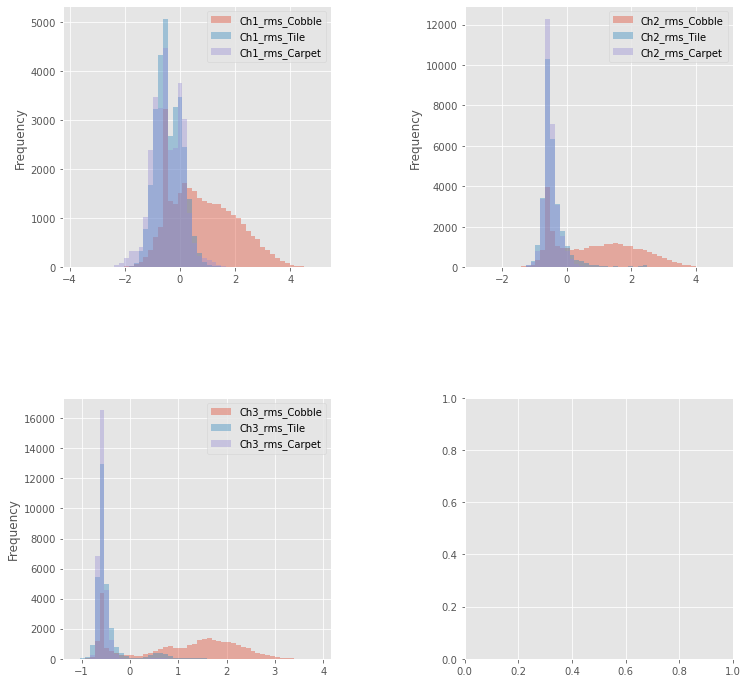

In [34]:
strSuff = 'rms_'
plotClasses(dfData, strSuff)

Same for the high frequency signal.

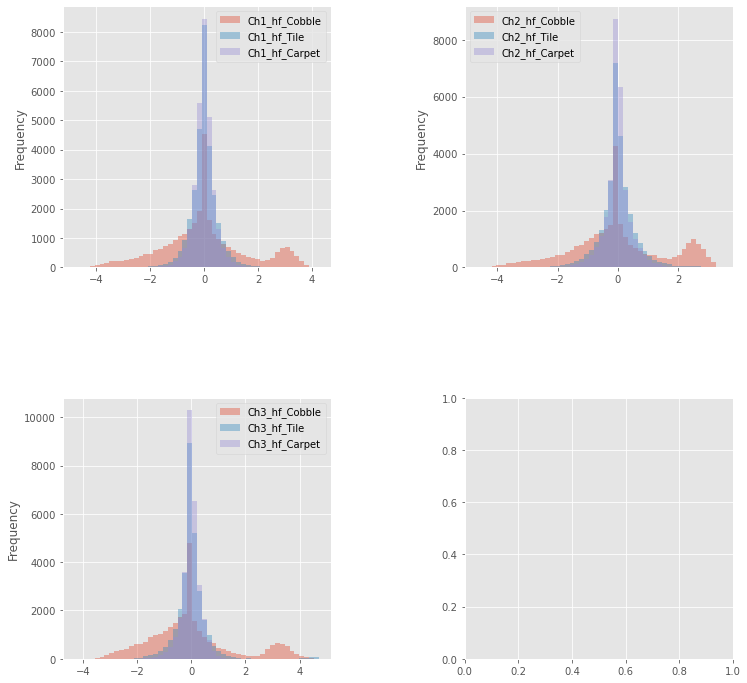

In [35]:
strSuff = 'hf_'
plotClasses(dfData, strSuff)

Not great separation for the peak value of the high frequency signal.

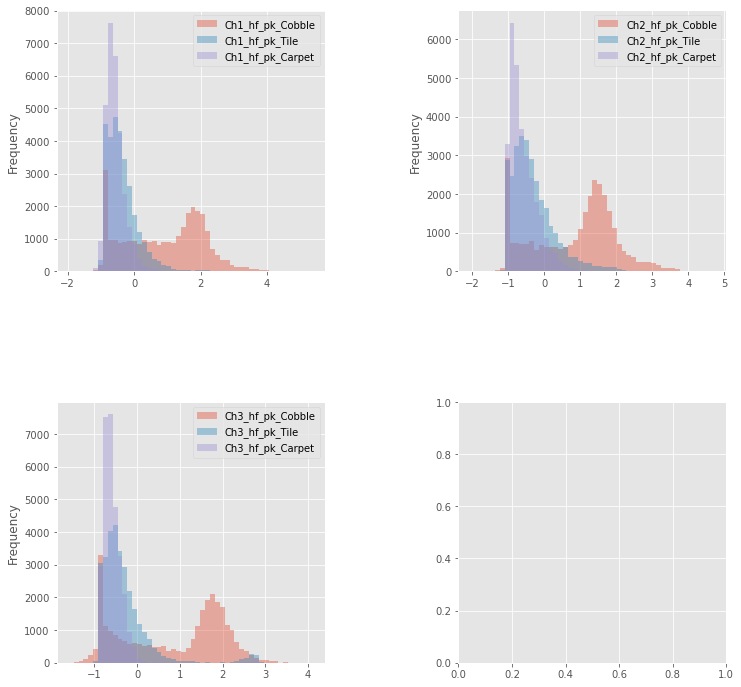

In [36]:
strSuff = 'hf_pk_'
plotClasses(dfData, strSuff)

With the peak feature, there is finally some separation of the tile and carpet.

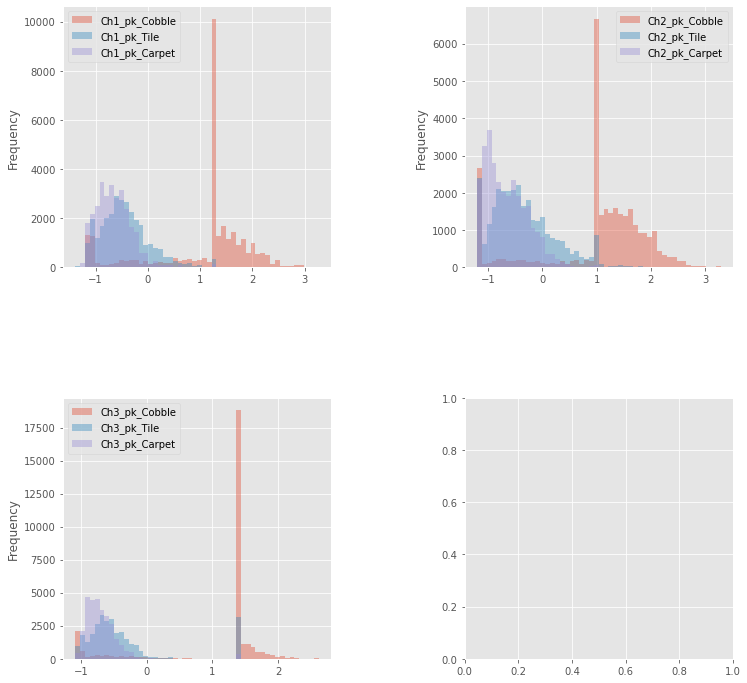

In [37]:
strSuff = 'pk_'
plotClasses(dfData, strSuff)

The peak value of the rolling mean gives us the best separation so far.

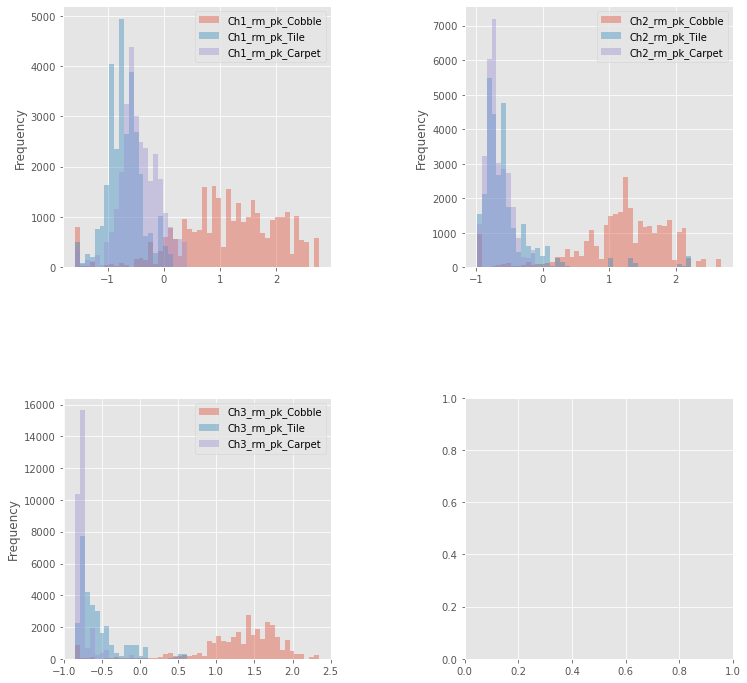

In [38]:
strSuff = 'rm_pk_'
plotClasses(dfData, strSuff)

The velocity also starts to separate out. There is still some overlap in the carpet and tile, but overall the three distributions can be seen.

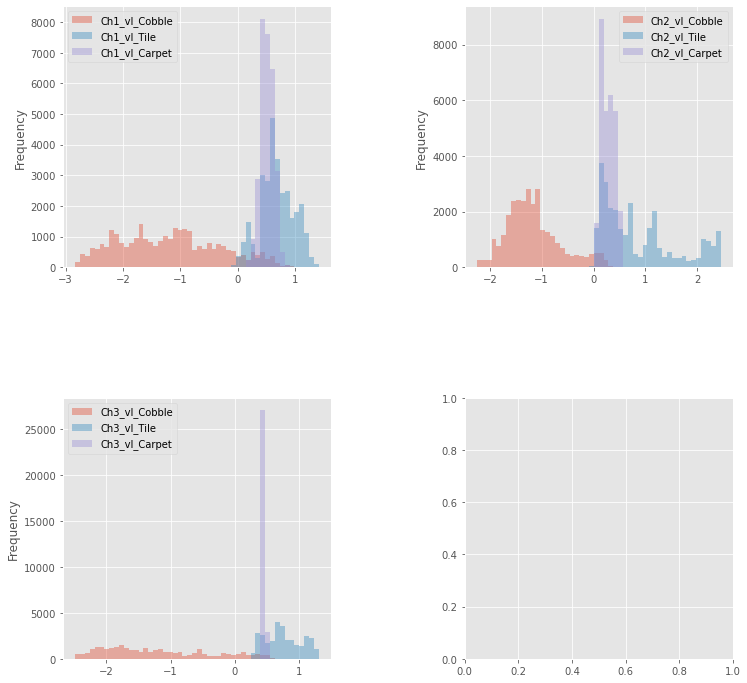

In [39]:
strSuff = 'vl_'
plotClasses(dfData, strSuff)
plt.savefig("HistVel.pdf", format='pdf')

Make sure the interesting features are uncorrelated.

C:\Users\Rainy\AppData\Local\Temp/ipykernel_20236/3175590994.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cax)


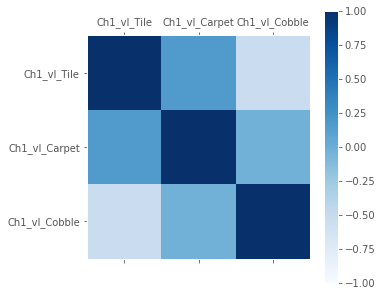

In [40]:
plt = plotCorrFeature(dfData, 'Ch1_vl', 'CorrVl.pdf', plt.cm.Blues)

C:\Users\Rainy\AppData\Local\Temp/ipykernel_20236/3175590994.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cax)


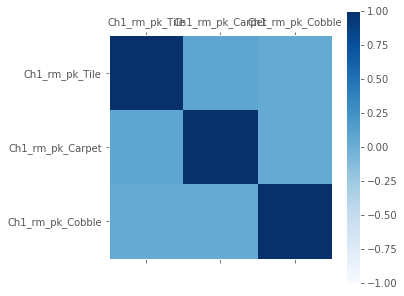

<module 'matplotlib.pyplot' from 'C:\\Users\\Rainy\\anaconda3\\envs\\envp39\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [41]:
plotCorrFeature(dfData, 'Ch1_rm_pk','CorrRmPk.pdf', plt.cm.Blues)

# Classification
Import the the required libraries. These links were helpful: http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html and http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html.

In [42]:
from sklearn import svm, datasets
import sklearn.ensemble as ens
import sklearn.tree as trees
import pydotplus as pdot
from sklearn.metrics import confusion_matrix
from IPython.display import Image

This function defines a nice way to visualize the confusion matrix. From scikit-learn documentation: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html.

In [43]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          strFile="Confusion.pdf"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(strFile, format='pdf')

This code selects the data and randomizes the order. 

In [44]:
# select our data
lstFeatures = ['Ch2_vl','Ch3_vl']
lstClassifiers = ['Tile','Cobble','Carpet']


In [45]:
dfData

,t,Ch1,Ch2,Ch3,Ch4,Surface,File,Ch1_rm,Ch2_rm,Ch3_rm,...,Ch3_pk,Ch4_pk,Ch1_rm_pk,Ch2_rm_pk,Ch3_rm_pk,Ch4_rm_pk,Ch1_vl,Ch2_vl,Ch3_vl,Ch4_vl
0,0.000,-0.122545,-0.154816,-0.316497,-0.172066,Cobble,Cobble1,-0.408900,-0.511572,-0.612444,...,-1.013793,-0.167611,-1.506700,-0.952745,-0.850769,-0.258074,0.445438,0.162124,0.460049,-0.259674
1,0.004,-0.121689,-0.152518,-0.323259,-0.172066,Cobble,Cobble1,-0.408900,-0.511572,-0.612444,...,-1.013793,-0.167611,-1.506700,-0.952745,-0.850769,-0.258074,0.442648,0.159870,0.456957,-0.259044
2,0.008,-0.119122,-0.147155,-0.315145,-0.172066,Cobble,Cobble1,-0.408900,-0.511572,-0.612444,...,-1.013793,-0.167611,-1.506700,-0.952745,-0.850769,-0.258074,0.439857,0.157615,0.453865,-0.258414
3,0.012,-0.125112,-0.152518,-0.313116,-0.167744,Cobble,Cobble1,-0.408900,-0.511572,-0.612444,...,-1.013793,-0.167611,-1.506700,-0.952745,-0.850769,-0.258074,0.437066,0.155361,0.450774,-0.257784
4,0.016,-0.125968,-0.147155,-0.314469,-0.167744,Cobble,Cobble1,-0.408900,-0.511572,-0.612444,...,-1.013793,-0.167611,-1.506700,-0.952745,-0.850769,-0.258074,0.434275,0.153107,0.447682,-0.257154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,59.980,-0.178169,-0.377748,-0.215069,0.035358,Tile,Tile2,-0.804396,-0.562353,-0.572365,...,-0.829335,0.116646,-1.157508,-0.941637,-0.750322,0.050955,0.451035,0.164477,0.463393,-0.261781
89996,59.984,-0.404085,0.144724,-0.387497,0.031036,Tile,Tile2,-0.804396,-0.562353,-0.572365,...,-0.829335,0.116646,-1.157508,-0.941637,-0.750322,0.050955,0.450333,0.164453,0.463330,-0.261412
89997,59.988,-0.369856,-0.098126,-0.305002,0.026715,Tile,Tile2,-0.804396,-0.562353,-0.572365,...,-0.829335,0.116646,-1.157508,-0.941637,-0.750322,0.050955,0.449632,0.164428,0.463267,-0.261043
89998,59.992,-0.309098,-0.192355,-0.127840,0.009430,Tile,Tile2,-0.804396,-0.562353,-0.572365,...,-0.829335,0.116646,-1.157508,-0.941637,-0.750322,0.050955,0.448931,0.164403,0.463204,-0.260673


In [46]:
# For testing of the code we want the same seed
RANDOM_SEED = 10234

# Shuffle the data
idx = np.arange(dfData.shape[0])
np.random.seed(RANDOM_SEED)
np.random.shuffle(idx)
dfDataTrain = dfData.iloc[idx[0:int(idx.size/2)], :]
dfDataTest = dfData.iloc[idx[int(idx.size/2):idx.size], :]

In [47]:
# Break the data into features and classes
TrainFeatures = dfDataTrain[lstFeatures]
TrainClasses = dfDataTrain['Surface']
TestFeatures = dfDataTest[lstFeatures]
TestClasses = dfDataTest['Surface']

### Build The Simple Model

In this section the data is fit to a model and plotted. The model uses decision trees because they are simple and perform well with non-linear data (refer to http://scikit-learn.org/stable/modules/tree.html#tree for more details on decision trees). This sacrifices some accuracy in the model, but the model should be simple enough to be implemented in the Arduino.

The modelling starts with a simple tree, only 2 levels deep since that could very likely be implemented in the Arduino.

In [48]:
# Configure the decision tree and perform the fit
tree_depth=2
dtTrain = trees.DecisionTreeClassifier(max_depth=tree_depth)
dtTrain = dtTrain.fit(TrainFeatures, TrainClasses)

Using matplot lib to visualize the tree

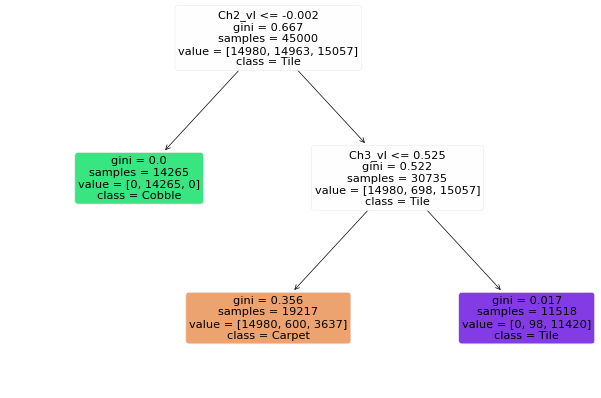

In [49]:
fig, axes = plt.subplots(dpi=100)
lst_tree = trees.plot_tree(dtTrain, feature_names=lstFeatures,
                          class_names=[lstClassifiers[2], lstClassifiers[1], lstClassifiers[0]],
                          filled=True, rounded=True)
fig.savefig('Stage1.pdf')

### Simple Model Results

The model results can also be summarized in something called a confusion matrix. The matrix has the correct results on the diagonals so these values should be high. For this fit, most of the samples fall on the diagonals. This is not a bad model so far.

Confusion matrix, without normalization
[[11420    98     0]
 [    0 14265     0]
 [ 3637   600 14980]]


C:\Users\Rainy\AppData\Local\Temp/ipykernel_20236/486511444.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


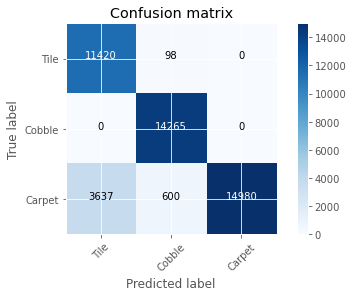

In [50]:
predTrainClasses = dtTrain.predict(TrainFeatures)
cnm = confusion_matrix(predTrainClasses, TrainClasses, labels=lstClassifiers)
plot_confusion_matrix(cnm, lstClassifiers,
                     title='Confusion matrix', cmap=plt.cm.Blues, strFile="ConfusionTrain.pdf")

The better indicator of performance will be on the test data. We still have high values in the diagonal terms, but there are also higher values in the off-diagonal terms. 

Confusion matrix, without normalization
[[11280   117     0]
 [    0 14341     0]
 [ 3663   579 15020]]


C:\Users\Rainy\AppData\Local\Temp/ipykernel_20236/486511444.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


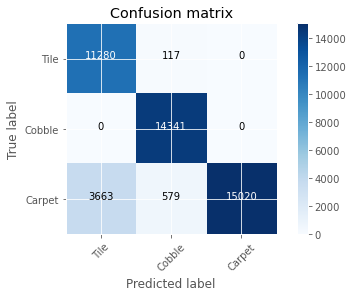

In [51]:
predTestClasses = dtTrain.predict(TestFeatures)
cnm = confusion_matrix(predTestClasses, TestClasses, labels=lstClassifiers)
plot_confusion_matrix(cnm, lstClassifiers, 
                      title='Confusion matrix', cmap=plt.cm.Blues, strFile="ConfusionTest.pdf")

### Simple Model Scatter Plot

Plot the data to understand how the model and data interact. One way to do this is to put the model on a contour plot and overlay it with the data. 

In [52]:
# mesh for the features
h=0.01
x_min, x_max = TrainFeatures[lstFeatures[0]].min() - 1, TrainFeatures[lstFeatures[0]].max() + 1
y_min, y_max = TrainFeatures[lstFeatures[1]].min() - 1, TrainFeatures[lstFeatures[1]].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

C:\Users\Rainy\anaconda3\envs\envp39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*

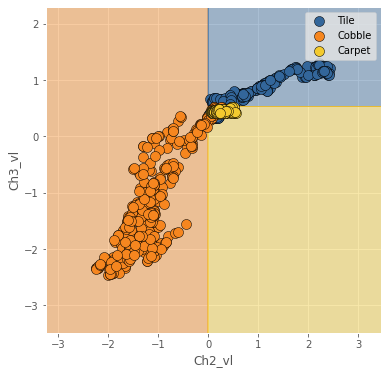

In [53]:
iClassifiers = len(lstClassifiers)

plt.figure(num=None, figsize=(6, 6))
Z = dtTrain.predict(np.c_[xx.ravel(), yy.ravel()])
dctTemp = {lstClassifiers[0]:0, lstClassifiers[1]:1, lstClassifiers[2]:2}
Zt = np.zeros_like(Z)
for idx in range(0,len(Z)):
    Zt[idx] = dctTemp[Z[idx]]
Zt = Zt.reshape(xx.shape)
cs = plt.contourf(xx, yy, Zt, cmap=cmap_surf, alpha=0.4)

for i, cIn in zip(range(iClassifiers), plot_colors_surf):
    idx = np.where(TrainClasses==lstClassifiers[i])[0]
    plt.scatter(TrainFeatures.iloc[idx[1:350],0], TrainFeatures.iloc[idx[1:350],1], label=lstClassifiers[i], 
                cmap=plot_colors_surf, c=cIn, edgecolor='black', s=100)
plt.legend()
plt.xlabel(lstFeatures[0])
plt.ylabel(lstFeatures[1])
plt.savefig("Scatter.pdf", format='pdf')

### Deeper Model

It is tempting to try to improve the model by adding complexity. The depth of the tree will be increased and plotted to compare to the simple model.

In [54]:
# Configure the decision tree and perform the fit
tree_depth=5
dtTrain3 = trees.DecisionTreeClassifier(max_depth=tree_depth)
dtTrain3 = dtTrain3.fit(TrainFeatures, TrainClasses)

Using matplot lib to visualize the tree

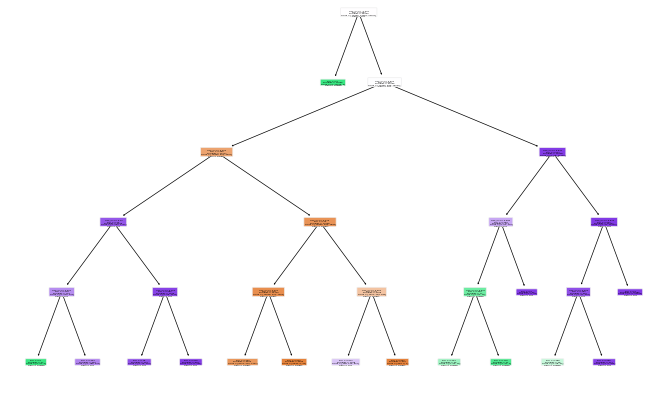

In [55]:
fig, axes = plt.subplots(dpi=100)
lst_tree = trees.plot_tree(dtTrain3, feature_names=lstFeatures,
                          class_names=[lstClassifiers[2], lstClassifiers[1], lstClassifiers[0]],
                          filled=True, rounded=True)
fig.savefig('Stage3.pdf')

### Deeper Model Confusion Matrix

That's quite a tree! It would be difficult to implement in an Arduino Uno. How does the performance look? 

Confusion matrix, without normalization
[[13753   372   408]
 [   36 14381     0]
 [ 1268   210 14572]]


C:\Users\Rainy\AppData\Local\Temp/ipykernel_20236/486511444.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


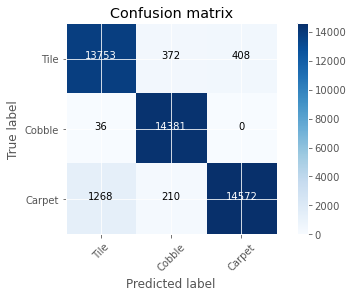

In [56]:
predTrainClasses3 = dtTrain3.predict(TrainFeatures)
cnm= confusion_matrix(predTrainClasses3, TrainClasses, labels=lstClassifiers)
plot_confusion_matrix(cnm, lstClassifiers, 
                      title='Confusion matrix', cmap=plt.cm.Blues, strFile="ConfusionTrainDeep.pdf")

The model seems to be improved. As mentioned before, the real proof will be on the test data.

Confusion matrix, without normalization
[[13637   371   382]
 [   32 14481     0]
 [ 1274   185 14638]]


C:\Users\Rainy\AppData\Local\Temp/ipykernel_20236/486511444.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


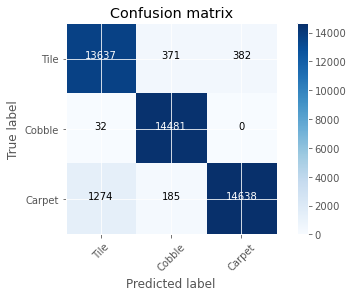

In [57]:
predTestClasses3 = dtTrain3.predict(TestFeatures)
cnm= confusion_matrix(predTestClasses3, TestClasses, labels=lstClassifiers)
plot_confusion_matrix(cnm, lstClassifiers, 
                      title='Confusion matrix', cmap=plt.cm.Blues, strFile="ConfusionTestDeep.pdf")

The additional layers did improve the model, but it is now complex and more difficult to code on an Arduino.

# Conclusion

The simple model seems like it will detect road surface. In a future step of the project, the model will be implemented on the Arduino and tested to see how well it works.